# Genome codification and Clustering
# Discovering Structure in Data
## Caulobacter crescentus

In [1]:
import numpy as np
import os.path
from io import StringIO
import itertools
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig_size = [8, 8]
plt.rcParams["figure.figsize"] = fig_size


## Load Genome file

In [2]:
def loadGenome(fname):
    genome=""
    with open(fname, "r") as f:
        _ = f.readline() # ignore the header
        l = f.readline()
        while l:
            genome += l[:-1] # ignore new line
            l = f.readline()
    GENOMESIZE=len(genome)
    return genome, GENOMESIZE

fname = "sequence.fasta"
genome, GENOMESIZE = loadGenome(fname)


## Check there are only letters: A, C, G and T

In [3]:
letters=list(set(genome))
print(letters)

['A', 'G', 'C', 'T']


## Define some parameters

In [4]:
BLOCKSIZE=300
WORDSIZE=[1,2,3,4]
NBLOCKS=GENOMESIZE//BLOCKSIZE

print(NBLOCKS)

13389


## Converting Text to a Numerical Table: calculate word frequency

A word is any continuous piece of text that contains several subsequent letters.
As there are no spaces in the text, separation into words is not unique.

The method we use is as follows. We clip the whole text into fragments of
300 letters in length and calculate the frequencies of short words (of length
1–4) inside every fragment. This will give us a description of the text in the
form of a numerical table. There will be four such tables for every short word
length from 1 to 4.
As there are only four letters, there are four possible words of length 1
(singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words
of length 3 (triplets) and 256 = 4^4 possible words of length 4 (quadruplets).
The first table contains four columns (frequency of every singlet) and the
number of rows equals the number of fragments. The second table has 16
columns and the same number of rows, and so on.

In [5]:
def getFeatures(genome, NBLOCKS, WORDSIZE):
    features={x : np.zeros((NBLOCKS, 4**x)) for x in WORDSIZE}
    for ws in WORDSIZE:
        lookUp = { y : x for x,y in enumerate([''.join(l) for l in itertools.product(*[letters]*ws)]) }
        for b in range(NBLOCKS):
            block = genome[b*BLOCKSIZE:(b+1)*BLOCKSIZE]
            for i in range(BLOCKSIZE//ws):
                word = block[i*ws:(i+1)*ws]
                features[ws][b,lookUp[word]] += 1
    return features

features = getFeatures(genome, NBLOCKS, WORDSIZE)

In [6]:
print(features[1])

[[ 61.  98.  87.  54.]
 [ 46. 104.  95.  55.]
 [ 52.  86. 110.  52.]
 ...
 [ 46. 106. 103.  45.]
 [ 52.  96. 100.  52.]
 [ 63.  94.  95.  48.]]


## Standardize data

All values std_val = (val - mean)/std. In this way std_values are zero centered and their standard deviation equals one 

In [7]:
def standardize(features, WORDSIZE):
    for ws in WORDSIZE:
        std_scale = preprocessing.StandardScaler().fit(features[ws])
        features[ws] = std_scale.transform(features[ws])
    return features

features = standardize(features, WORDSIZE)


In [8]:
print(features[1])

[[ 1.29672179 -0.28457926 -1.53190207  0.56629092]
 [-0.37620026  0.36419168 -0.65731332  0.67915292]
 [ 0.29296856 -1.58212116  0.9825406   0.34056692]
 ...
 [-0.37620026  0.58044866  0.21727544 -0.44946708]
 [ 0.29296856 -0.50083625 -0.11069534  0.34056692]
 [ 1.51977807 -0.71709323 -0.65731332 -0.11088108]]


## Reduce dimensionality using Principal Component Analysis (PCA)

Principal Compoent Analysis (PCA) would deserve a couple of weeks explanations. We will very roughly explain it in a couple of slides.

In [9]:
def runPCA(features, WORDSIZE, n_components=2):
    featuresPCA={}
    for ws in WORDSIZE:
        pca = PCA(n_components=n_components).fit(features[ws])
        featuresPCA[ws] = pca.transform(features[ws])
    return featuresPCA

featuresPCA = runPCA(features, WORDSIZE)


In [10]:
print(featuresPCA[1])

[[ 1.83566551  0.34039593]
 [ 0.28411927  1.03958447]
 [ 0.6343608  -1.3241864 ]
 ...
 [-0.81381669  0.1465157 ]
 [ 0.625002   -0.17536656]
 [ 1.40250883 -0.77918009]]


## Visualize reduced data 

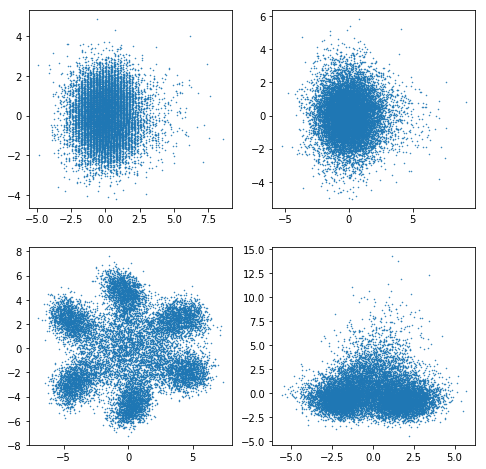

In [11]:
fig, axes = plt.subplots(2,2)
axes[0,0].scatter(featuresPCA[1].T[0], featuresPCA[1].T[1], s=0.25)
axes[0,1].scatter(featuresPCA[2].T[0], featuresPCA[2].T[1], s=0.25)
axes[1,0].scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=0.25)
axes[1,1].scatter(featuresPCA[4].T[0], featuresPCA[4].T[1], s=0.25)


## K-means and its plot (nice :-)

We'll see some slides to introduce the K-means algorithm. For now it suffices to know that it looks for the cluster that minimizes the distance of datapoints in the same clusters and maximizes the distance between cluters. The output is a set of cluter labels for the datapoints

In [12]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(features[3])

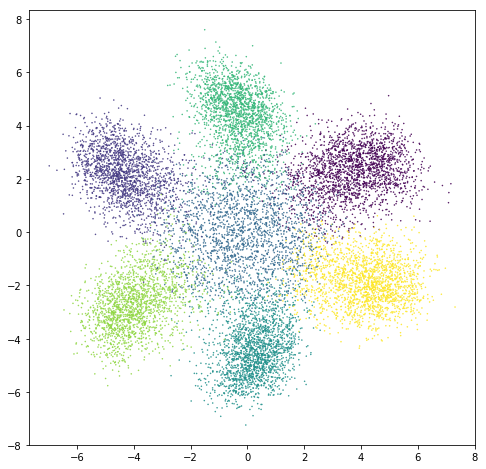

In [13]:
fig, ax = plt.subplots(1,1)
ax.scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=0.25, c=kmeans.labels_)

## Plotting again to obtain labels 
In order to get a lable for each cluster we need to plot them separately. This is too complex in my opinion!

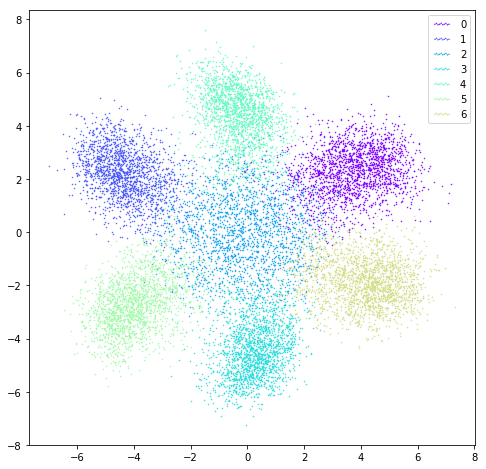

In [14]:
import matplotlib.cm as cm

x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))

fig, ax = plt.subplots(1,1)
for i, g in enumerate(np.unique(kmeans.labels_)):
    ix = np.where(kmeans.labels_ == g)
    ax.scatter(featuresPCA[3].T[0][ix], featuresPCA[3].T[1][ix], s=0.25, color=colors[i], label = g)
ax.legend(scatterpoints = 10)
plt.show()

## Distance between datapoints

We need to define the concept of distance between datapoints. The most commonly used distance is the Euclidean distance $d_{euc}$ because it holds the following properties:
* $d_{euc}(a,b) \ge 0$ and is 0 only if $a=b$
* $d_{euc}(a,b) \le d_{euc}(a,c) + d_{euc}(c,b)$ (triangular inequality)

In a d-dimensional space the euclidean distance is defined as:
$$d_{euc} = \Big[\sum_{i=0}^{d} (a_i - b_i)^2 \Big]^{\frac {1}{2}} = \big[(a -b)(a-b)^T\big]^{\frac {1}{2}}$$

## Inspect the distance between data elements
We do that since it is the first time we work with k-means and distances

In [16]:
print(kmeans.labels_[0:50])

[2 1 1 1 0 0 3 3 6 0 2 1 1 3 3 3 1 2 2 3 3 3 3 3 4 4 2 3 3 3 3 3 3 3 3 3 3
 3 1 1 1 1 1 1 1 1 1 4 0 0]


In [17]:
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric('euclidean')
print(dist.pairwise(features[3][4:9]))

[[ 0.          8.92058595 11.27597556 11.07435164  8.56466652]
 [ 8.92058595  0.          9.55790994  9.1248157   8.82974052]
 [11.27597556  9.55790994  0.          7.47435221  7.64167182]
 [11.07435164  9.1248157   7.47435221  0.          9.04711941]
 [ 8.56466652  8.82974052  7.64167182  9.04711941  0.        ]]


# Analize results

## Number of data in each cluster

In [15]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({0: 2020, 3: 1975, 2: 1935, 4: 1916, 6: 1910, 1: 1836, 5: 1797})


## Quality measures: Silhouette

A good clustering is one with **coherent** and **separated** clusters. That is datapoints in a cluster are close to each other (coherent) and datapoints in different clusters are far away (separated). The Silhouette meausre tries to combine both.

The *Silhouette* uses two values. Given a deatapoint $i$: 
* $a(i)$ the average distance between $i$ and its cluster-mates (the smaller the better) 
* $b(i)$ the average distance between $i$ and all the datapoints that belong to the nearest cluster of which $i$ is not a memeber

The final value of the Silhouette is calculated as the average for all datapoints of: $$s(i)={\frac {b(i)-a(i)}{\max\{a(i),b(i)\}}}$$

From the definition it can be observed that $-1 \le s(i) \le 1$ and that 
for $s(i)$ to be close to one must happend that ${\displaystyle a(i)\ll b(i)}$


In [37]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=7, random_state=0).fit(features[3])
print('Silhouette word size 3 and k=7: ', silhouette_score(features[3], kmeans.labels_))


Silhouette word size 3 and k=7:  0.115775186779792


#### Let us compare the Silhouette value above with the one from a random cluster

In [38]:
import random

random_labels = random.choices(range(0, 8), k=len(features[3]))
print('Silhouette word size 3 and random cluster: ', silhouette_score(features[3], random_labels))


Silhouette word size 3 and random cluster:  -0.004619031928704127


## How many clusters?
Silhouette is a measure also used to determine the optimum number of clusters

In [43]:
def silhouette(i, data):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(data)
    return silhouette_score(data, kmeans.labels_)

In [22]:
quality = [silhouette(i, features[3]) for i in range(2,10)]
for i, q in enumerate(quality):
    print("n_cluster: ", i+2, ", silhuette: ", q )

n_cluster:  2 , silhuette:  0.11604415552406339
n_cluster:  3 , silhuette:  0.12063134802538451
n_cluster:  4 , silhuette:  0.11129235561906525
n_cluster:  5 , silhuette:  0.1145440311113899
n_cluster:  6 , silhuette:  0.10773332419556576
n_cluster:  7 , silhuette:  0.115775186779792
n_cluster:  8 , silhuette:  0.1121035846075596
n_cluster:  9 , silhuette:  0.0996489768201504


It looks like having 3 clusters is the best!!! 
This contradicts our intuition from the graph above. Let's draw the clustering with three clusters.

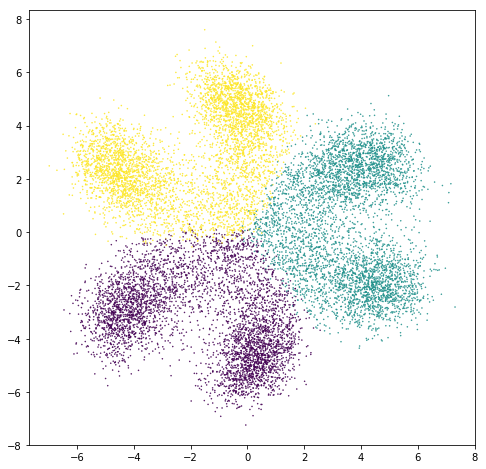

In [23]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(features[3])
fig, ax = plt.subplots(1,1)
ax.scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=0.25, c=kmeans.labels_)

# Size 4 words

In [44]:
quality = [silhouette(i, features[4]) for i in range(2,10)]
for i, q in enumerate(quality):
    print("n_cluster: ", i+2, ", silhuette: ", q )

n_cluster:  2 , silhuette:  0.011297612003642227
n_cluster:  3 , silhuette:  -0.0007037541072548368
n_cluster:  4 , silhuette:  -0.0009384853477162234
n_cluster:  5 , silhuette:  -0.00030533863654143767
n_cluster:  6 , silhuette:  -0.009131277540219139
n_cluster:  7 , silhuette:  -0.012476155774879627
n_cluster:  8 , silhuette:  -0.011233749478726992
n_cluster:  9 , silhuette:  -0.011819575659750328


# Size 2 words

In [45]:
quality = [silhouette(i, features[2]) for i in range(2,10)]
for i, q in enumerate(quality):
    print("n_cluster: ", i+2, ", silhuette: ", q )

n_cluster:  2 , silhuette:  0.07244148826956875
n_cluster:  3 , silhuette:  0.05764379554882365
n_cluster:  4 , silhuette:  0.05459708726293813
n_cluster:  5 , silhuette:  0.056320072650698653
n_cluster:  6 , silhuette:  0.05429479409701275
n_cluster:  7 , silhuette:  0.05366850055186509
n_cluster:  8 , silhuette:  0.0538454230513491
n_cluster:  9 , silhuette:  0.053967742938602015


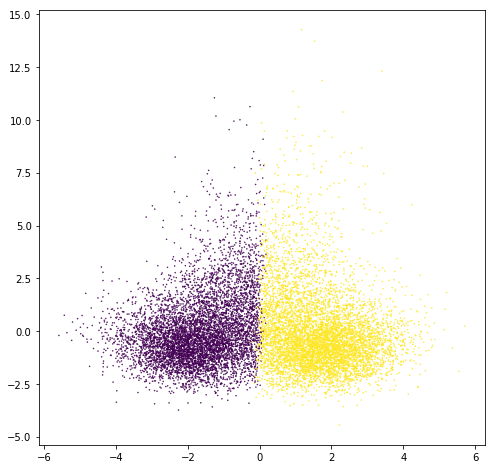

In [48]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(features[4])
fig, ax = plt.subplots(1,1)
ax.scatter(featuresPCA[4].T[0], featuresPCA[4].T[1], s=0.25, c=kmeans2.labels_)

In [49]:
silhouette_score(features[4], kmeans2.labels_)

0.011297612003642227

In [51]:
featuresPCA3 = runPCA(features, WORDSIZE, 3)

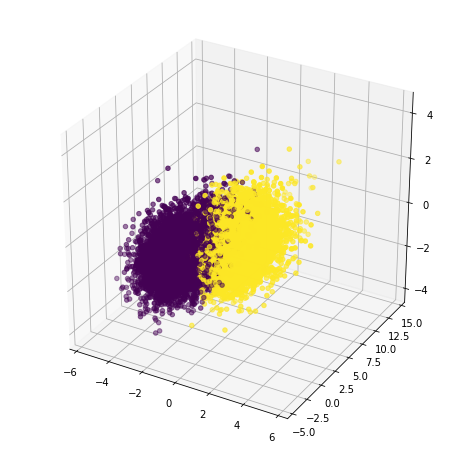

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(featuresPCA3[4].T[0], featuresPCA3[4].T[1], featuresPCA3[2].T[2], c=kmeans2.labels_)
